In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio
from tqdm import tqdm

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
from networkx import from_numpy_matrix, degree_centrality, closeness_centrality, betweenness_centrality, subgraph_centrality
# from sklearn.kernel_ridge import KernelRidge

/Users/lindenmp/opt/anaconda3/envs/neurodev_cs_predictive/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.7, the latest is 0.3.9.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
sys.path.append('/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/1_code/')
from func import set_proj_env, my_get_cmap, get_fdr_p, get_fdr_p_df, node_strength, ave_control

In [4]:
parc_str = 'schaefer' # 'schaefer' 'lausanne' 'glasser'
parc_scale = 200 # 200/400 | 125/250 | 360
edge_weight = 'streamlineCount' # 'streamlineCount' 'volNormStreamline'
parcel_names, parcel_loc, drop_parcels, num_parcels = set_proj_env(parc_str = parc_str, parc_scale = parc_scale, edge_weight = edge_weight)

In [5]:
# output file prefix
run_hemi = ''
if run_hemi == 'ipsi':
    outfile_prefix = parc_str+'_'+str(parc_scale)+'_'+edge_weight+'_ipsi_'
elif run_hemi == 'contra':
    outfile_prefix = parc_str+'_'+str(parc_scale)+'_'+edge_weight+'_contra_'
else:
    outfile_prefix = parc_str+'_'+str(parc_scale)+'_'+edge_weight+'_'
outfile_prefix

'schaefer_200_streamlineCount_'

In [6]:
# we want to calculate conn features including subcortex
# drop brainstem but retain subcortex.
# here because conn features have already been calculate, we actually drop the brainstem from parcel_loc
if parc_str == 'lausanne':
    parcel_loc = parcel_loc[parcel_loc != 2]
    num_parcels = len(parcel_loc)
print(num_parcels)

200


### Setup directory variables

In [7]:
print(os.environ['PIPELINEDIR'])
if not os.path.exists(os.environ['PIPELINEDIR']): os.makedirs(os.environ['PIPELINEDIR'])

/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/2_pipeline


In [8]:
figdir = os.path.join(os.environ['OUTPUTDIR'], 'figs')
print(figdir)
if not os.path.exists(figdir): os.makedirs(figdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/3_output/figs


In [9]:
phenos = ['Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg']
phenos_label = ['Overall Psychopathology','Psychosis (Positive)','Psychosis (Negative)']
phenos_short = ['Ov. Psy.','Psy. (pos)','Psy. (neg)']

print(phenos)

# metrics = ['str', 'ac']
metrics = ['str', 'ac', 'bc', 'cc', 'sgc']
algs = ['rr', 'krr_rbf']
scores = ['corr', 'rmse']

['Overall_Psychopathology', 'Psychosis_Positive', 'Psychosis_NegativeDisorg']


## Setup plots

In [10]:
if not os.path.exists(figdir): os.makedirs(figdir)
os.chdir(figdir)
sns.set(style='white', context = 'paper', font_scale = 1)
sns.set_style({'font.family':'sans-serif', 'font.sans-serif':['Public Sans']})
cmap = my_get_cmap('pair')

## Load data

In [11]:
df = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'store', outfile_prefix+'df.csv'))
df.set_index(['bblid', 'scanid'], inplace = True)

df_node = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'out', outfile_prefix+'X.csv'))
df_node.set_index(['bblid', 'scanid'], inplace = True)

df_node_ac_overc = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'out', outfile_prefix+'X_ac_c.csv'))
df_node_ac_overc.set_index(['bblid', 'scanid'], inplace = True)

df_node_ac_i2 = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'out', outfile_prefix+'X_ac_i2.csv'))
df_node_ac_i2.set_index(['bblid', 'scanid'], inplace = True)

df_pheno = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'out', outfile_prefix+'y.csv'))
df_pheno.set_index(['bblid', 'scanid'], inplace = True)

c = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'out', outfile_prefix+'c.csv'))
c.set_index(['bblid', 'scanid'], inplace = True); print(c.shape)
c.columns

(1068, 4)


Index(['ageAtScan1', 'sex', 'mprage_antsCT_vol_TBV', 'dti64MeanRelRMS'], dtype='object')

In [12]:
print(np.all(df_node.filter(regex = 'ac') == df_node_ac_i2))
print(np.sum(df_node.filter(regex = 'ac').corrwith(df_node_ac_i2, method='spearman') < 0.99))

True
0


0.56
-0.78
-0.75


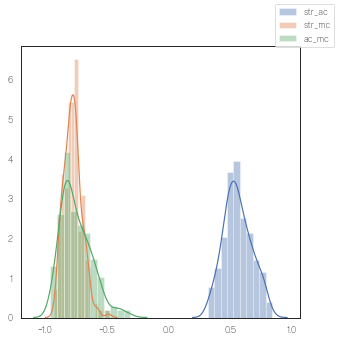

In [13]:
f, ax = plt.subplots()
f.set_figwidth(5)
f.set_figheight(5)

df_x = df_node.filter(regex = 'str'); df_x.columns = np.arange(df_x.shape[1])         
df_y = df_node.filter(regex = 'ac'); df_y.columns = np.arange(df_y.shape[1])
xy_corr = df_x.corrwith(df_y, method = 'pearson')
print(np.round(xy_corr.mean(),2))
sns.distplot(xy_corr, ax=ax, label='str_ac')

df_x = df_node.filter(regex = 'str'); df_x.columns = np.arange(df_x.shape[1])         
df_y = df_node.filter(regex = 'mc'); df_y.columns = np.arange(df_y.shape[1])
xy_corr = df_x.corrwith(df_y, method = 'pearson')
print(np.round(xy_corr.mean(),2))
sns.distplot(xy_corr, ax=ax, label='str_mc')

df_x = df_node.filter(regex = 'ac'); df_x.columns = np.arange(df_x.shape[1])         
df_y = df_node.filter(regex = 'mc'); df_y.columns = np.arange(df_y.shape[1])
xy_corr = df_x.corrwith(df_y, method = 'pearson')
print(np.round(xy_corr.mean(),2))
sns.distplot(xy_corr, ax=ax, label='ac_mc')

f.legend()

In [14]:
# # replace ac with initial condition = 2
# ac_labels = ['ac_' + str(i) for i in range(num_parcels)]
# df_node.loc[:,ac_labels]

### Nuisance regression

In [15]:
# Note, this nuisance regression made no difference.
# Leaving off for simplicity of reporting.

# nuis_reg = KernelRidge(kernel='rbf'); nuis_reg.fit(c, df_node)
# X_pred = nuis_reg.predict(c); df_node = df_node - X_pred

# nuis_reg = KernelRidge(kernel='rbf'); nuis_reg.fit(c, df_node_ac_overc)
# X_pred = nuis_reg.predict(c); df_node_ac_overc = df_node_ac_overc - X_pred

In [16]:
g = 0
gradient = np.loadtxt(os.path.join(os.environ['PIPELINEDIR'], '2_compute_gradient', 'out', parc_str+'_'+str(parc_scale)+'_'+'pnc_grads_template.txt'))[:,g]

In [17]:
if parc_str == 'lausanne' and len(gradient) == num_parcels:
    print('cutting subcortex')
    gradient = gradient[parcel_loc==1]

In [18]:
# load spin test outputs
if parc_scale != 250:
    spin_indices = pd.read_csv(os.path.join(os.environ['PROJDIR'],'rotated_ind_'+parc_str+str(parc_scale)+'.csv'),sep=',' , header=None).values
    num_perms = spin_indices.shape[1]

In [19]:
# if run_ipsi == True and parc_str == 'schaefer' and parc_scale == 200: # reting ipsilateral hemisphere (optional)
#     num_parcels = int(num_parcels/2)
#     gradient = gradient[:num_parcels]
#     spin_indices = spin_indices[:num_parcels,:]

In [20]:
A = np.load(os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'store', outfile_prefix+'A.npy'))
A = np.mean(A, axis = 2)
np.any(np.isnan(A))

False

In [21]:
# density
np.count_nonzero(np.triu(A))/((A.shape[0]**2-A.shape[0])/2)

0.795175879396985

In [22]:
# threshold to mean density of cohort
print(df.loc[:,'network_density'].mean())
thresh = np.percentile(A,100-(df.loc[:,'network_density'].mean()*100))
A[A < thresh] = 0

0.12274993883274048


In [23]:
# new density
np.count_nonzero(np.triu(A))/((A.shape[0]**2-A.shape[0])/2)

0.12336683417085427

In [24]:
r_vals = pd.DataFrame(index = metrics, columns = phenos)
p_vals = pd.DataFrame(index = metrics, columns = phenos)

for metric in metrics:
    for pheno in phenos:
        X = df_node.filter(regex = metric).copy()
        if parc_str == 'lausanne':
            X = X.iloc[:,parcel_loc==1]
        y = df_pheno.loc[:,pheno].copy()
        
        X_y_corr = X.corrwith(y, method = 'spearman').values

        my_corr = sp.stats.spearmanr(gradient, X_y_corr)
        r_vals.loc[metric,pheno] = my_corr[0]
        p_vals.loc[metric,pheno] = my_corr[1]
        
p_vals = get_fdr_p_df(p_vals, rows = True)

In [25]:
r_vals

,Overall_Psychopathology,Psychosis_Positive,Psychosis_NegativeDisorg
str,-0.103675,-0.00378159,-0.0231576
ac,-0.280102,-0.292101,0.331508
bc,-0.127089,0.0313703,0.0545984
cc,-0.0843501,-0.00686717,-0.0233526
sgc,0.0219215,-0.0206,-0.102139


In [26]:
r_vals[p_vals < .05]

,Overall_Psychopathology,Psychosis_Positive,Psychosis_NegativeDisorg
str,NaN,NaN,NaN
ac,-0.280102,-0.292101,0.331508
bc,NaN,NaN,NaN
cc,NaN,NaN,NaN
sgc,NaN,NaN,NaN


In [27]:
my_ac = ave_control(A)
my_str = node_strength(A)
G = from_numpy_matrix(A)
my_bc = np.array(list(betweenness_centrality(G, normalized=False).values()))
my_cc = np.array(list(closeness_centrality(G).values()))
my_sgc = np.array(list(subgraph_centrality(G).values()))
    
my_ac = sp.stats.boxcox(my_ac)[0]
my_str = sp.stats.boxcox(my_str)[0]

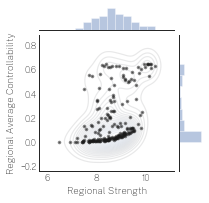

In [28]:
f = sns.jointplot(x = my_str, y = my_ac)
f.fig.set_figwidth(2.5)
f.fig.set_figheight(2.5)
# f.annotate(sp.stats.spearmanr)
f.plot_joint(sns.kdeplot, zorder = 0, n_levels = 20, alpha = 0.1)
f.plot_joint(plt.scatter, c = "k", s = 10, linewidth = 2, marker = ".", alpha = 0.5)
f.ax_joint.collections[0].set_alpha(0)
f.ax_joint.set_xlabel('Regional Strength')
f.ax_joint.set_ylabel('Regional Average Controllability')
f.ax_joint.tick_params(pad = -2)
f.savefig(outfile_prefix+'regional_str_vs_ac.png', dpi = 300, bbox_inches = 'tight')

In [29]:
sp.stats.pearsonr(my_ac,my_str)

(0.44710351522403025, 3.202964824941121e-11)

In [30]:
sp.stats.spearmanr(my_ac,my_str)

SpearmanrResult(correlation=0.544707117677942, pvalue=7.558846170508737e-17)

In [31]:
c_params = np.array([10, 100, 1000, 10000])
c_params

array([   10,   100,  1000, 10000])

In [32]:
ac_orig_r = np.zeros(c_params.shape,)
ac_str_r = np.zeros(c_params.shape,)

for i, c_param in enumerate(c_params):
    ac_tmp = ave_control(A, c = c_param)
    ac_tmp = sp.stats.boxcox(ac_tmp)[0]
    
    ac_orig_r[i] = sp.stats.spearmanr(my_ac,ac_tmp)[0]
    ac_str_r[i] = sp.stats.spearmanr(my_str,ac_tmp)[0]

In [33]:
ac_orig_r[-1]

0.5660601515037876

In [34]:
ac_str_r[-1]

0.9284032100802522

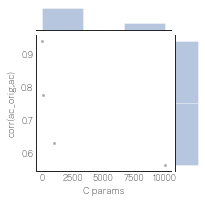

In [35]:
f = sns.jointplot(x = c_params, y = ac_orig_r)
f.fig.set_figwidth(2.5)
f.fig.set_figheight(2.5)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)
f.ax_joint.set_xlabel('C params')
f.ax_joint.set_ylabel('corr(ac_orig,ac)')
f.ax_joint.tick_params(pad = -2)
f.savefig(outfile_prefix+'regional_c_vs_corr(ac_orig,ac).png', dpi = 300, bbox_inches = 'tight')

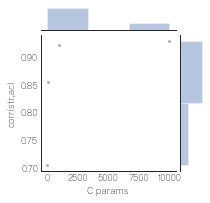

In [36]:
f = sns.jointplot(x = c_params, y = ac_str_r)
f.fig.set_figwidth(2.5)
f.fig.set_figheight(2.5)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)
f.ax_joint.set_xlabel('C params')
f.ax_joint.set_ylabel('corr(str,ac)')
f.ax_joint.tick_params(pad = -2)
f.savefig(outfile_prefix+'regional_c_vs_corr(str,ac).png', dpi = 300, bbox_inches = 'tight')

## Correlation between metric gradient value

In [37]:
# plot_me = my_cc.copy()

# f, ax = plt.subplots()
# f.set_figwidth(2)
# f.set_figheight(2)
# sns.regplot(x = gradient, y = plot_me, color = 'gray', scatter = False)
# plt.scatter(x = gradient, y = plot_me, marker = 'o', s = 10, c = gradient, cmap = 'viridis', alpha=0.75, linewidth = 1)
# ax.set_xlabel('Regional gradient value')
# # ax.set_ylabel(metric)
# # ax.set_ylim([0.25,0.9])
# # ax.set_xlim([-0.13,0.115])
# ax.tick_params(pad = -2)

# textstr = 'r = {:.2f}'.format(sp.stats.pearsonr(gradient,plot_me)[0])
# ax.text(0.95, 0.95, textstr, transform=ax.transAxes,
#         verticalalignment='top', horizontalalignment='right')

# # f.savefig(outfile_prefix+'regional_gradient_'+str(g)+'_vs_corr(str,ac).svg', dpi = 300, bbox_inches = 'tight')

## Correlation between (x,y) cross-subject similarity and gradient value

In [38]:
# num_perms = spin_indices.shape[1]
num_perms = 10000

In [39]:
if parc_str == 'schaefer' and parc_scale == 200 and not run_hemi:
    metric_pairs = ['str_ac', 'str_bc', 'str_cc', 'str_sgc',
                    'ac_bc', 'ac_cc', 'ac_sgc',
                    'bc_cc', 'bc_sgc',
                    'cc_sgc',
                    'str_mc', 'ac_mc']
else:
#     metric_pairs = ['str_ac', 'bc_cc']
    metric_pairs = ['str_ac',]
metric_pairs

['str_ac',
 'str_bc',
 'str_cc',
 'str_sgc',
 'ac_bc',
 'ac_cc',
 'ac_sgc',
 'bc_cc',
 'bc_sgc',
 'cc_sgc',
 'str_mc',
 'ac_mc']

In [40]:
# # age split

# # age_split = c['ageAtScan1'] < c['ageAtScan1'].mean()
# age_split = c['ageAtScan1'] > c['ageAtScan1'].mean()

# c = c.loc[age_split,:]
# c.drop(labels=['ageAtScan1'], axis=1, inplace=True)

# df_node = df_node.loc[age_split,:]
# df_pheno = df_pheno.loc[age_split,:]

In [41]:
emp_corr = np.zeros(len(metric_pairs))
p_val = np.zeros(len(metric_pairs))

for m, metric_pair in enumerate(metric_pairs):
    print(metric_pair)
    metric_x = metric_pair.split('_')[0]
    metric_y = metric_pair.split('_')[1]

    df_x = df_node.filter(regex = metric_x)
    df_y = df_node.filter(regex = metric_y)
    if parc_str == 'lausanne':
        df_x = df_x.iloc[:,parcel_loc==1]
        df_y = df_y.iloc[:,parcel_loc==1]

    df_x.columns = np.arange(df_x.shape[1])
    df_y.columns = np.arange(df_y.shape[1])
    xy_corr = df_x.corrwith(df_y, method = 'pearson')

    emp_corr[m] = sp.stats.pearsonr(gradient,xy_corr)[0]

    if parc_scale != 250:
        spun_corr = np.zeros(num_perms)
        for i in tqdm(np.arange(num_perms)):
            spun_corr[i] = sp.stats.pearsonr(gradient,xy_corr[spin_indices[:,i]-1])[0]

        if emp_corr[m] < 0:
            p_val[m] = np.sum(spun_corr < emp_corr[m])/num_perms
        else:
            p_val[m] = np.sum(spun_corr > emp_corr[m])/num_perms
    else:
        p_val[m] = sp.stats.pearsonr(gradient,xy_corr)[1]

# p_val = get_fdr_p(p_val)

  3%|▎         | 286/10000 [00:00<00:03, 2854.43it/s]

str_ac


  2%|▏         | 218/10000 [00:00<00:04, 2178.82it/s]

str_bc


  3%|▎         | 302/10000 [00:00<00:03, 3015.39it/s]

str_cc


  3%|▎         | 303/10000 [00:00<00:03, 3029.06it/s]

str_sgc


  3%|▎         | 300/10000 [00:00<00:03, 2996.07it/s]

ac_bc


  6%|▌         | 597/10000 [00:00<00:03, 3044.33it/s]

ac_cc


  3%|▎         | 305/10000 [00:00<00:03, 3044.22it/s]

ac_sgc


  3%|▎         | 313/10000 [00:00<00:03, 3115.98it/s]

bc_cc


  6%|▌         | 601/10000 [00:00<00:03, 2968.61it/s]

bc_sgc


  3%|▎         | 311/10000 [00:00<00:03, 3101.51it/s]

cc_sgc


  3%|▎         | 319/10000 [00:00<00:03, 3188.92it/s]

str_mc


  6%|▌         | 599/10000 [00:00<00:03, 3004.30it/s]

ac_mc


100%|██████████| 10000/10000 [00:03<00:00, 3102.25it/s]


In [42]:
sns.set(style='white', context = 'paper', font_scale = 0.8)
sns.set_style({'font.family':'sans-serif', 'font.sans-serif':['Public Sans']})

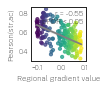

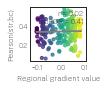

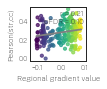

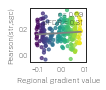

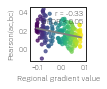

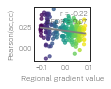

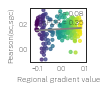

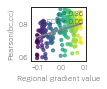

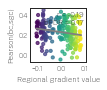

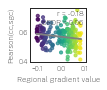

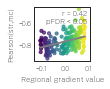

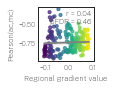

In [43]:
for m, metric_pair in enumerate(metric_pairs):
    metric_x = metric_pair.split('_')[0]
    metric_y = metric_pair.split('_')[1]

    df_x = df_node.filter(regex = metric_x)            
    df_y = df_node.filter(regex = metric_y)
    if parc_str == 'lausanne':
        df_x = df_x.iloc[:,parcel_loc==1]
        df_y = df_y.iloc[:,parcel_loc==1]
    
    df_x.columns = np.arange(df_x.shape[1])
    df_y.columns = np.arange(df_y.shape[1])
    xy_corr = df_x.corrwith(df_y, method = 'pearson')

    f, ax = plt.subplots()
#     f.set_figwidth(1.25)
#     f.set_figheight(1.25)
    f.set_figwidth(1)
    f.set_figheight(1)
    sns.regplot(x = gradient, y = xy_corr, color = 'gray', scatter = False)
    plt.scatter(x = gradient, y = xy_corr, marker = 'o', s = 10, c = gradient, cmap = 'viridis', alpha=0.75, linewidth = 1)
    ax.set_xlabel('Regional gradient value')
    ax.set_ylabel('Pearson('+metric_x+','+metric_y+')')
    # ax.set_ylim([0.25,0.9])
#     ax.set_xlim([-0.13,0.115])
    ax.set_xlim([gradient.min()+gradient.min()*.25,
                 gradient.max()+gradient.max()*.25])
    ax.tick_params(pad = -2)

    if p_val[m] < 0.05:
        textstr = 'r = {:.2f}\npFDR < 0.05'.format(emp_corr[m])
    else:
        textstr = 'r = {:.2f}\npFDR = {:.2f}'.format(emp_corr[m], p_val[m])
    ax.text(0.95, 0.95, textstr, transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='right')
    
    f.savefig(outfile_prefix+'regional_gradient_'+str(g)+'_vs_corr('+metric_x+','+metric_y+').svg', dpi = 300, bbox_inches = 'tight')

## Correlation between (ac,str) cross-subject similarity and gradient value

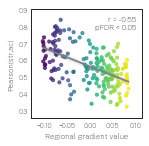

In [44]:
m=0
metric_pair = metric_pairs[m]
metric_x = metric_pair.split('_')[0]
metric_y = metric_pair.split('_')[1]

df_x = df_node.filter(regex = metric_x)            
df_y = df_node.filter(regex = metric_y)
if parc_str == 'lausanne':
    df_x = df_x.iloc[:,parcel_loc==1]
    df_y = df_y.iloc[:,parcel_loc==1]

df_x.columns = np.arange(df_x.shape[1])
df_y.columns = np.arange(df_y.shape[1])
xy_corr = df_x.corrwith(df_y, method = 'pearson')

f, ax = plt.subplots()
f.set_figwidth(2)
f.set_figheight(2)
sns.regplot(x = gradient, y = xy_corr, color = 'gray', scatter = False)
plt.scatter(x = gradient, y = xy_corr, marker = 'o', s = 10, c = gradient, cmap = 'viridis', alpha=0.75, linewidth = 1)
ax.set_xlabel('Regional gradient value')
ax.set_ylabel('Pearson(str,ac)')
ax.set_ylim([0.25,0.9])
ax.set_xlim([-0.13,0.115])
ax.tick_params(pad = -2)

if p_val[m] < 0.05:
    textstr = 'r = {:.2f}\npFDR < 0.05'.format(emp_corr[m])
else:
    textstr = 'r = {:.2f}\npFDR = {:.2f}'.format(emp_corr[m], p_val[m])
ax.text(0.95, 0.95, textstr, transform=ax.transAxes,
        verticalalignment='top', horizontalalignment='right')

f.savefig(outfile_prefix+'figure3_regional_gradient_'+str(g)+'_vs_corr('+metric_x+','+metric_y+').svg', dpi = 300, bbox_inches = 'tight')

## Correlation between (ac_over_c,str) cross-subject similarity and gradient value

In [45]:
c_params = np.array([10, 100, 1000, 10000])
c_params

array([   10,   100,  1000, 10000])

In [46]:
emp_corr = np.zeros(len(metric_pairs))
p_val = np.zeros(len(metric_pairs))

for m, c_param in enumerate(c_params):
    print(c_param)
    df_x = df_node.filter(regex = 'str')
    df_y = df_node_ac_overc.filter(regex = 'ac_c'+str(c_param)+'_')
    if parc_str == 'lausanne':
        df_x = df_x.iloc[:,parcel_loc==1]
        df_y = df_y.iloc[:,parcel_loc==1]
        
    df_x.columns = np.arange(df_x.shape[1])
    df_y.columns = np.arange(df_y.shape[1])
    xy_corr = df_x.corrwith(df_y, method = 'pearson')

    emp_corr[m] = sp.stats.pearsonr(gradient,xy_corr)[0]

    spun_corr = np.zeros(num_perms)
    for i in tqdm(np.arange(num_perms)):
        spun_corr[i] = sp.stats.pearsonr(gradient,xy_corr[spin_indices[:,i]-1])[0]

    if emp_corr[m] < 0:
        p_val[m] = np.sum(spun_corr < emp_corr[m])/num_perms
    else:
        p_val[m] = np.sum(spun_corr > emp_corr[m])/num_perms

p_val = get_fdr_p(p_val)

  3%|▎         | 282/10000 [00:00<00:03, 2818.70it/s]

10


  6%|▌         | 595/10000 [00:00<00:03, 2981.34it/s]

100


  6%|▌         | 558/10000 [00:00<00:03, 2756.05it/s]

1000


  3%|▎         | 308/10000 [00:00<00:03, 3071.71it/s]

10000


100%|██████████| 10000/10000 [00:03<00:00, 3092.00it/s]


10
100
1000
10000


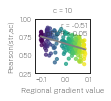

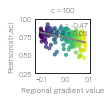

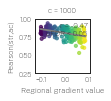

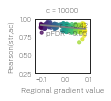

In [47]:
for m, c_param in enumerate(c_params):
    print(c_param)
    df_x = df_node.filter(regex = 'str')
    df_y = df_node_ac_overc.filter(regex = 'ac_c'+str(c_param)+'_')
    if parc_str == 'lausanne':
        df_x = df_x.iloc[:,parcel_loc==1]
        df_y = df_y.iloc[:,parcel_loc==1]
        
    df_x.columns = np.arange(df_x.shape[1])
    df_y.columns = np.arange(df_y.shape[1])
    xy_corr = df_x.corrwith(df_y, method = 'pearson')

    f, ax = plt.subplots()
#     f.set_figwidth(1.25)
#     f.set_figheight(1.25)
    f.set_figwidth(1)
    f.set_figheight(1)
    sns.regplot(x = gradient, y = xy_corr, color = 'gray', scatter = False)
    plt.scatter(x = gradient, y = xy_corr, marker = 'o', s = 10, c = gradient, cmap = 'viridis', alpha=0.75, linewidth = 1)
    ax.set_xlabel('Regional gradient value')
#     ax.set_xlabel('')
    ax.set_ylabel('Pearson(str,ac)')
    ax.set_ylim([0.25,1])
    ax.set_xlim([-0.12,0.12])
    ax.set_xlim([gradient.min()+gradient.min()*.25,
                 gradient.max()+gradient.max()*.25])
    ax.tick_params(pad = -2)

    ax.set_title('c = ' + str(c_param))
    
    if p_val[m] < 0.05:
        textstr = 'r = {:.2f}\npFDR < 0.05'.format(emp_corr[m])
    else:
        textstr = 'r = {:.2f}\npFDR = {:.2f}'.format(emp_corr[m], p_val[m])
    ax.text(0.95, 0.95, textstr, transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='right')

    f.savefig(outfile_prefix+'regional_gradient_'+str(g)+'_vs_corr(str,ac)_c_'+str(c_param)+'.svg', dpi = 300, bbox_inches = 'tight')